# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

###  Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape =X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes =len(list(set(y_train)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

<Container object of 43 artists>

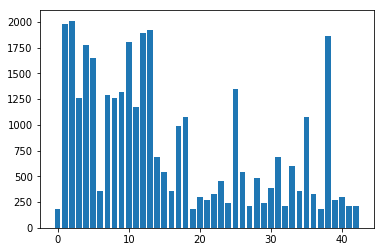

In [3]:
import matplotlib.pyplot as plt
data=[list(y_train).count(i) for i in list(set(y_train))]
plt.figure()
plt.bar(list(range(len(data))),data)

#a.savefig('traindata.png')

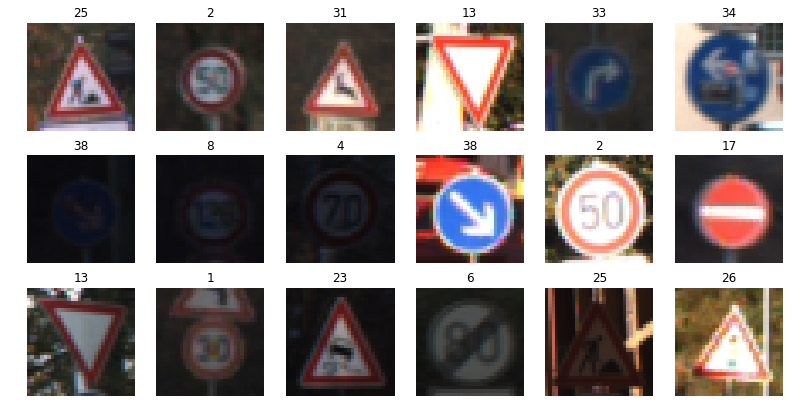

In [4]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
fig, axs = plt.subplots(3,6, figsize=(15, 6))
fig.subplots_adjust(0.2,0.01)
axs = axs.ravel()
for i in range(18):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

#fig.savefig('Visulaisation.png')

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)
#Dataset preprocessing :

Larger data set is important for a good Model to predict the class correctly. The provided training data set has fewer number of samples for a few classes. Therefore firstly I augmented the training data set by adding slightly modified images of the existing training images. Class IDs are sorted based on number of training samples corresponding to each class and then first 15 classes with least number of samples are chosen. The chosen images are then rotated slightly to generate modified image for training.

Further the images in augmented data set are then converted to grayscale. It reduces computation load without compromising on features. The grayscaled images are then normalized about zero. Normalised data set is uniformly in all the dimensions and it helps in optimising the parameters faster and effectively.

Last step of preprocessing is to shuffle the normalized data to train the model effectively for maximum number of classes in a single batch.

In [5]:
index=np.argsort(data)
image_index=[np.argwhere(y_train==i) for i in index[:15]]
a=[image_index[i][j][0] for i in range(len(image_index)) for j in range(len(image_index[i]))]

import random
(h, w) = (32,32)
scale = 1.0
rotated1=X_train[a]
rotated2=X_train[a]
rotated3=X_train[a]
for i in range(len(a)): 
    angle1=random.randint(-10,10)
    angle2=random.randint(-5,5)
    angle3=random.randint(-15,15)
    M1 = cv2.getRotationMatrix2D((16,16), angle1, scale)
    M2 = cv2.getRotationMatrix2D((14,14), angle2, scale)
    M3 = cv2.getRotationMatrix2D((18,18), angle3, scale)
    rotated1[i]= cv2.warpAffine(X_train[a[i]], M1, (h, w))
    rotated2[i]= cv2.warpAffine(X_train[a[i]], M2, (h, w))    
    rotated3[i]= cv2.warpAffine(X_train[a[i]], M3, (h, w))
X_train1=np.concatenate((X_train,rotated1,rotated2,rotated3))
y_train=np.concatenate((y_train,y_train[a],y_train[a],y_train[a]))

<Container object of 43 artists>

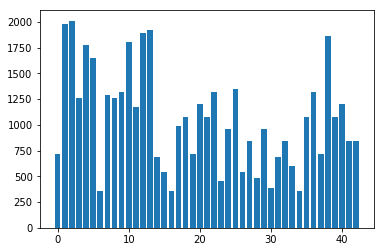

In [6]:
data=[list(y_train).count(i) for i in list(set(y_train))]
fig=plt.figure()
plt.bar(list(range(len(data))),data)
#fig.savefig('Augmented_data.png')

In [7]:
# Normalizing data
X_train=((np.mean(X_train1,3,keepdims=True))-128)/128
X_valid=((np.mean(X_valid,3,keepdims=True))-128)/128
X_test=((np.mean(X_test,3,keepdims=True))-128)/128

# shuffle data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

#Dataset preprocessing :

Larger data set is important for a good Model to predict the class correctly. The provided training data set has fewer number of samples for a few classes. Therefore firstly I augmented the training data set by adding slightly modified images of the existing training images. Class IDs are sorted based on number of training samples corresponding to each class and then first 15 classes with least number of samples are chosen. The chosen images are then rotated slightly to generate modified image for training.

Further the images in augmented data set are then converted to grayscale. It reduces computation load without compromising on features. The grayscaled images are then normalized about zero. Normalised data set is uniformly in all the dimensions and it helps in optimising the parameters faster and effectively.

Last step of preprocessing is to shuffle the normalized data to train the model effectively for maximum number of classes in a single batch.


The LeNet model is used as the base architecture. The number of parameters in hidden layers are modified and tuned in iterative process. It was noted that the traffic signs have different shapes and marking and thus have several different features like edges, curves,contrast etc. Therefore number of parameters are increased in iterative fashion to achieve 97% validation accuracy. 

First layer is responsible for edges. Therefore number of filters is chosen and tried to cater edges and curves of markings.
Hidden Layer 1 : 32x32x1 -> 5x5 convolution with 20 filters -> 28x28x20  -> ReLU -> maxPooling 2x2 -> 14x14x20

Second layer is responsible for basic underlying shapes of signs. Therefore number of filters is chosen and tried to cater general shapes
Hidden Layer 2 : 14x14x20 -> 5x5 convolution with 80 filters -> 10x10x80  -> ReLU -> maxPooling 2x2 -> 5x5x80

Size of Connected layers were chosen and tried to train the model differentiate between closely resembling signs.
Fully connected layer 1 : flatten(5x5x80) -> 2000 ->Dropout layer while dropout probability to avoid overfitting 50%-> 240

Fully connected layer 2 : 240 -> Dropout layer probability 50% to avoid overfitting->150

Fully connected layer 3 : 150 -> 43

The number of parameters were initialised considering all the factors explained above. However final number of parameters is fixed after several iterations.

In [8]:
from tensorflow.contrib.layers import flatten
import tensorflow as tf
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    d1=20#20
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x20. 
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, d1), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(d1))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28xd1. Output = 14x14xd1.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    d2= 80
    # SOLUTION: Layer 2: Convolutional. Output = 10x10xd2.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, d1, d2), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(d2))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5xd2.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    

    # SOLUTION: Flatten. Input = 5x5x24. Output = 25xd2. 6x6
    fc0   = flatten(conv2)#2
    
    d3= 240
    # SOLUTION: Layer 3: Fully Connected. Input = 25xd2. Output = d3.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(25*d2, d3), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(d3))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1,0.5)    
       
    d4= 150
    # SOLUTION: Layer 4: Fully Connected. Input = d3. Output = d4.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(d3, d4), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(d4))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2,0.5)
    
    
    # SOLUTION: Layer 5: Fully Connected. Input = d4. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(d4, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

x=tf.placeholder(tf.float32,(None,32,32,1)) 
y=tf.placeholder(tf.int32,(None))
one_hot_y1=tf.one_hot(y,43)
rate=.00035
logits1=LeNet(x)

cross_entropy=tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y1,logits=logits1)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)    

print("Done")

Done


In [9]:
correct_prediction =  tf.equal(tf.argmax(logits1,1),tf.argmax(one_hot_y1,1))
accuracy_operation =  tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    BATCH_SIZE=64
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

#Model Training and solution Approach

Adamoptmizer is used with training batch size 43. 

Target is to achieve validation accuracy of 97% or above. The pipeline stops training the model if the target accuracy is achieved or epoch value hits 100, whichever happens first.

The learning rate is kept .00035. It slows down the learning process a bit but helps in achieving the target.

The graph presented below shows the learning progress.

Training ...

EPOCH1 
Validation accuracy=0.55
Test accuracy=0.56

EPOCH2 
Validation accuracy=0.75
Test accuracy=0.74

EPOCH3 
Validation accuracy=0.81
Test accuracy=0.81

EPOCH4 
Validation accuracy=0.85
Test accuracy=0.84

EPOCH5 
Validation accuracy=0.87
Test accuracy=0.87

EPOCH6 
Validation accuracy=0.89
Test accuracy=0.88

EPOCH7 
Validation accuracy=0.90
Test accuracy=0.89

EPOCH8 
Validation accuracy=0.90
Test accuracy=0.90

EPOCH9 
Validation accuracy=0.92
Test accuracy=0.90

EPOCH10 
Validation accuracy=0.92
Test accuracy=0.91

EPOCH11 
Validation accuracy=0.92
Test accuracy=0.91

EPOCH12 
Validation accuracy=0.92
Test accuracy=0.92

EPOCH13 
Validation accuracy=0.93
Test accuracy=0.92

EPOCH14 
Validation accuracy=0.93
Test accuracy=0.92

EPOCH15 
Validation accuracy=0.93
Test accuracy=0.92

EPOCH16 
Validation accuracy=0.93
Test accuracy=0.92

EPOCH17 
Validation accuracy=0.94
Test accuracy=0.93

EPOCH18 
Validation accuracy=0.95
Test accuracy=0.92

EPOCH19 
Validation acc

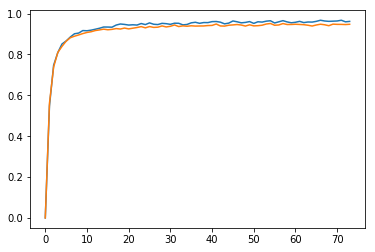

In [10]:
batch_Size=64

import random
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training ...")
    print()
    validation_accuracy=0
    epoch=0
    Vacc=list(range(101))
    tacc=list(range(101))
    while((validation_accuracy<0.969) & (epoch<100)):
        
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples,batch_Size) :
            end = offset + batch_Size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
    
        validation_accuracy = evaluate(X_valid, y_valid)
        test_accuracy = evaluate(X_test, y_test)                             
        print("EPOCH{} ".format(epoch+1) )
        epoch+=1
        Vacc[epoch]=validation_accuracy
        tacc[epoch]=test_accuracy
        print("Validation accuracy={:.2f}".format(validation_accuracy))
        print("Test accuracy={:.2f}".format(test_accuracy))
        print()
    plt.plot(list(range(epoch)),Vacc[:epoch])   
    plt.plot(list(range(epoch)),tacc[:epoch],)  
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess,'Lenet')
    print("Model saved")

## Step 3: Test a Model on New Images

#Acquiring New Images

7 images of traffic signs are found on the internet. Chosen images address to the challenge that two signs could be mistaken.For example signs of speed limit 50 and speed limit 60 may have almost similar feature values, which may cause an under trained model to make mistakes. Similarly an under trained model can make mistake in predicting signs between man at work and bumpy road signs. Even with validatin accuracy of 95% , model can make mistake. The signs are chosen because of their shape and markings. I tried to choose images such that they should cover maximum number of basic shapes and features. The images and performances are presented below

Therefor I tageted 97% of validation accuracy to make the model successful and I tuned the model parameters accordingly. 

### Load and Output the Images

In [11]:
import glob
import cv2
import matplotlib.image as mpimg
import tensorflow as tf

images = []

for i, img in enumerate(glob.glob('./web_images/test*.png')):
    images.append(cv2.imread(img))

web_test=((np.mean(images,3,keepdims=True))-128)/128  
web_labels = [3,34,25,1,38,18,11]

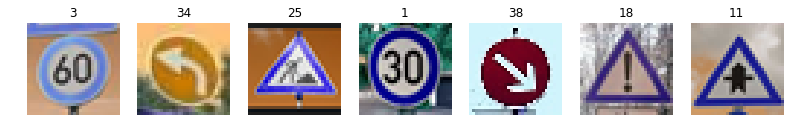

In [12]:
%matplotlib inline
fig, axs = plt.subplots(1,7, figsize=(15, 6))
fig.subplots_adjust(0.2,0.01)
axs = axs.ravel()
for i in range(7):
    axs[i].axis('off')
    axs[i].imshow(images[i])
    axs[i].set_title(web_labels[i])
#fig.savefig('web_images.png')

### Analyze Performance

The accuracy of test set data is 95%. Whereas Accuracy of web images test set is 100%. 

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./Lenet.meta')
    saver3.restore(sess, "./Lenet")
    my_accuracy = evaluate(web_test, web_labels)
    print("Web Test Set Accuracy = {:.3f}".format(my_accuracy))

INFO:tensorflow:Restoring parameters from ./Lenet
Web Test Set Accuracy = 1.000


### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./Lenet


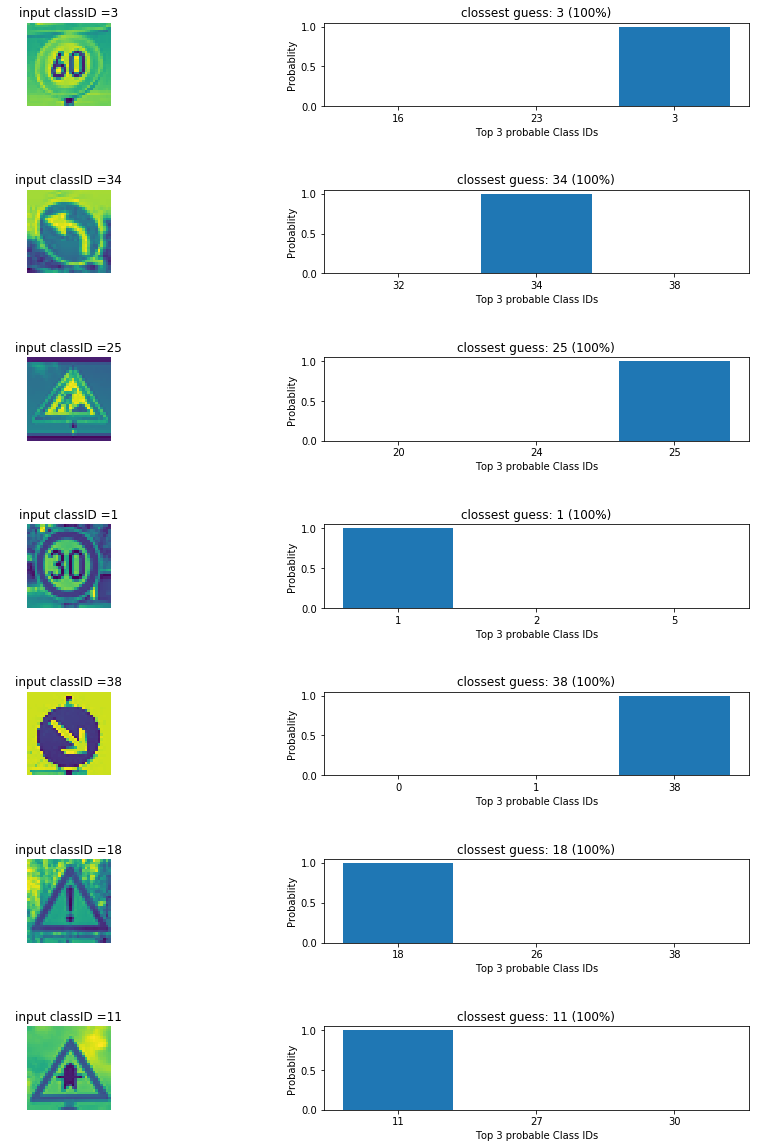

In [14]:
softmax_logits = tf.nn.softmax(logits1)
top_k = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    s = tf.train.import_meta_graph('./Lenet.meta')
    s.restore(sess, "./Lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: web_test})
    my_top_k = sess.run(top_k, feed_dict={x: web_test})

    
    fig, axs = plt.subplots(len(web_test),2, figsize=(16, 20))
    fig.subplots_adjust(hspace = 1, wspace=.1)
    axs = axs.ravel()
    
    for i, image in enumerate(web_test):
        axs[2*i].axis('off')
        axs[2*i].imshow(image[:,:,0])     
        axs[2*i].set_title('input classID ={}'.format(web_labels[i]))
        
        data=[my_top_k[0][i][j] for j in range(3)]
        clss=[str(my_top_k[1][i][j]) for j in range(3)]
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        
        axs[2*i+1].bar(clss,data)
        axs[2*i+1].set_title('clossest guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        axs[2*i+1].set_ylabel('Probablity')
        axs[2*i+1].set_xlabel('Top 3 probable Class IDs')


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

The model meets the expectations and correctly predicts the class. The top five softmax probalities are presented below.

For all the seven images the model predicted with almost 100% accuracy .

The accuracy of test set data is 95%. Whereas Accuracy of web images test set is 100%.

The top 5 probalities in first column is almost 1 and correctly predicts the corresponding class ID.

In [15]:
print(my_top_k)

TopKV2(values=array([[  1.00000000e+00,   6.16860385e-09,   2.77240258e-15,
          1.26405448e-17,   3.09514752e-18],
       [  1.00000000e+00,   6.47125582e-12,   1.61599209e-13,
          1.97056896e-14,   5.67842368e-18],
       [  9.99988198e-01,   1.02212998e-05,   9.74449790e-07,
          2.78693165e-07,   2.59059590e-07],
       [  1.00000000e+00,   1.15765580e-29,   1.07370453e-35,
          4.36949614e-37,   1.23311260e-37],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   6.82243590e-28,   2.94246154e-30,
          1.88220729e-32,   1.30024931e-34],
       [  1.00000000e+00,   1.68822782e-27,   2.42806057e-37,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[ 3, 16, 23, 28, 29],
       [34, 38, 32,  3, 15],
       [25, 20, 24, 31, 30],
       [ 1,  2,  5,  6,  4],
       [38,  0,  1,  2,  3],
       [18, 38, 26, 11, 31],
       [11, 27, 30,  0,  1]], dtype=in